In [1]:
import argparse
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import stats
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint 
import scipy.optimize as spo
from scipy.optimize import curve_fit
import time 
import json 
import os
from IPython.display import display, clear_output
from iminuit import Minuit
import uproot
import itertools

In [2]:
def plot_rate(file, int1=(21000,32000),int2=(50000,70000),avolt=13):
    data = pd.read_csv(file,delimiter="\s+", skiprows=14,
                   names=['a','b','c','d','e','f','rate','g','h','i','sec'])
    plt.figure(figsize=(12,6))
    plt.xlabel('Hours [h]', ha='right',x=1,fontsize=12)
    plt.ylabel('Rate [Hz]', ha='right',x=1,fontsize=12)
    mean1 = np.mean(data['rate'][int1[0]:int1[1]])
    mean2 = np.mean(data['rate'][int2[0]:int2[1]])
    std1 = np.std(data['rate'][int1[0]:int1[1]])
    std2 = np.std(data['rate'][int2[0]:int2[1]])
    plt.axvspan(data['sec'][int1[0]]/3600,data['sec'][int1[1]]/3600,color='r',alpha=0.2,
               label=f'rate {mean1:.1f}±{std1:.1f} Hz')
    plt.axvspan(data['sec'][int2[0]]/3600,data['sec'][int2[1]]/3600,color='m',alpha=0.2,
               label=f'rate {mean2:.1f}±{std2:.1f} Hz')
    #plt.xlim(40,110)
    #plt.ylim(0,750)
    plt.plot(data['sec']/3600,data['rate'])
    plt.title(f'ABALONE at {avolt} kV')
    #print(data['rate'])
    plt.legend(fontsize=14)

In [154]:
file13='/data/abalone/ABALONE_RampingUp/13kV_100threshold.txt'
file14='/data/abalone/ABALONE_RampingUp/14kV_100threshold.txt'
file15='/data/abalone/ABALONE_RampingUp/15kV_100threshold.txt'
file16='/data/abalone/ABALONE_RampingUp/16kV_100threshold_150721.txt'
file17='/data/abalone/ABALONE_RampingUp/17kV_100threshold_150721.txt'# 12:40 15/07/2021 -> 18 kV 17:40 16/07/2021
file18='/data/abalone/ABALONE_RampingUp/18kV_100threshold_19072021.txt'
file20a='/data/abalone/ABALONE_RampingUp/20kV_100threshold_200721.txt'
file20b='/data/abalone/ABALONE_RampingUp/20kV_100threshold_270721.txt'

## configuration with 3D ring
rate7a = '/data/abalone/ABALONE_RampingUp/2021_08_05_Rate_7kV.txt'
rate7b = '/data/abalone/ABALONE_RampingUp/2021_08_06_Rate_7kV.txt'
rate8 = '/data/abalone/ABALONE_RampingUp/2021_08_06_Rate_8kV.txt'
rate9 = '/data/abalone/ABALONE_RampingUp/2021_08_06_Rate_9kV.txt'
rate10a = '/data/abalone/ABALONE_RampingUp/2021_08_09_Rate_10kV.txt'
rate10b = '/data/abalone/ABALONE_RampingUp/2021_08_10_Rate_10kV.txt'
rate11a = '/data/abalone/ABALONE_RampingUp/2021_08_11_Rate_11kV.txt'
rate11b = '/data/abalone/ABALONE_RampingUp/2021_08_11_Rate_11kV_T1653.txt'
rate11c = '/data/abalone/ABALONE_RampingUp/2021_08_11_Rate_11kV.txt'
rate14 = '/data/abalone/ABALONE_RampingUp/2021_08_11_Rate_14kV.txt'
rate17 = '/data/abalone/ABALONE_RampingUp/2021_08_12_Rate_17kV.txt'

In [164]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
def plot_all_rate(file1, file2 = None, file3 = None, file4 = None, file5 = None, file6 = None, file7 = None,
                  file8 = None, file9 = None, file10 = None,
                  hours = (13,14,15,16,17,18), avolts = (13,14,15,16,17,18), width = 1,
                  ylim = None, xlim = None ):
    data = pd.read_csv(file1,delimiter="\s+", skiprows=14,
                      names=['a','b','c','d','e','f','rate','g','h','i','sec'])
    if file2 is not None:
        df2 = pd.read_csv(file2,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df2, ignore_index=True)
    if file3 is not None:
        df3 = pd.read_csv(file3,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df3, ignore_index=True)
    if file4 is not None:
        df4 = pd.read_csv(file4,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df4, ignore_index=True)
    if file5 is not None:
        df5 = pd.read_csv(file5,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df5, ignore_index=True)
    if file6 is not None:
        df6 = pd.read_csv(file6,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df6, ignore_index=True)
    if file7 is not None:
        df7 = pd.read_csv(file7,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df7, ignore_index=True)
    if file8 is not None:
        df8 = pd.read_csv(file8,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df8, ignore_index=True)
    if file9 is not None:
        df9 = pd.read_csv(file9,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df9, ignore_index=True)
    if file10 is not None:
        df10 = pd.read_csv(file10,delimiter="\s+", skiprows=14,
                          names=['a','b','c','d','e','f','rate','g','h','i','sec'])
        data = data.append(df10, ignore_index=True)
    plt.figure(figsize=(12,6))
    plt.xlabel('Hours [h]', ha='right',x=1,fontsize=12)
    plt.ylabel('Rate [Hz]', ha='right',x=1,fontsize=12)
    #mean2 = np.mean(data['rate'][int2[0]:int2[1]])
    #std2 = np.std(data['rate'][int2[0]:int2[1]])
    #plt.axvspan(data['sec'][int1[0]]/3600,data['sec'][int1[1]]/3600,color='r',alpha=0.2,
    #           label=f'rate {mean1:.1f}±{std1:.1f} Hz')
    #)
    time = data.index*2/3600
    rate = moving_average(data['rate'], width)
    colors = ['r','b','g','c','m','y','brown','tab:pink']
    means = np.zeros(8)
    for i, [hour, avolt, color] in enumerate(zip(hours, avolts, colors)):
        try: ll, rr = hours[i+1]-1,hours[i+1]-0.5
        except: ll, rr = time[-1]-0.5,time[-1]
        ill, irr = np.where(time>=ll)[0][0], np.where(time>=rr)[0][0]
        means[i] = np.mean(rate[ill:irr])
        std = np.std(rate[ill:irr])
        #print(ll,rr,ill,irr,means[i],std)
        plt.axvline(hour,label=f'ABALONE at {avolt} kV, rate: ${means[i]:.0f}\pm{std:.0f}$ Hz',c=color)
        #plt.axvspan(ll,rr,color='r',alpha=0.2)
    if xlim is not None: plt.xlim(xlim[0],xlim[1])
    if ylim is not None: plt.ylim(ylim[0],ylim[1])
    plt.plot(time,rate,c='black')
    #plt.title(f'ABALONE at {avolt} kV')
    #print(data['rate'])
    plt.legend(fontsize=14)
    return avolts, means

/usr/share/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/share/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


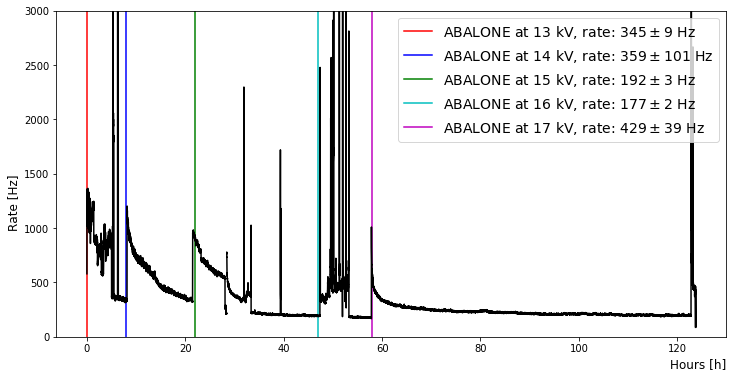

In [138]:
avolts, means = plot_all_rate(file13,file14,file15,file16,file17,hours=(0,8,22,47,58),width=20,ylim=(0,3000))

/usr/share/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/share/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


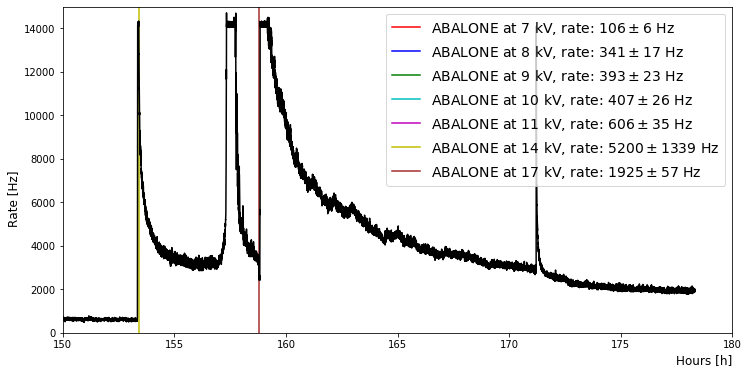

In [182]:
avolts, means = plot_all_rate(rate7a,rate8,rate9,rate10a,rate10b,rate11a,rate11b,rate14,rate17,
                              hours=(0,15,17.7,86,131.25,153.4,158.8),avolts=(7,8,9,10,11,14,17),width=2,ylim=(0,15000),
                             xlim=(150,180))

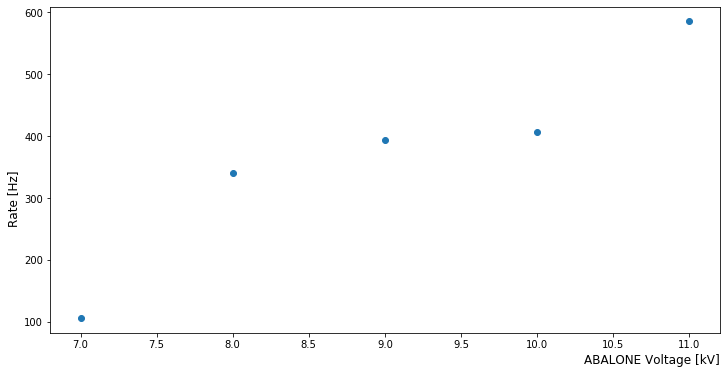

In [147]:
plt.figure(figsize=(12,6))
plt.xlabel('ABALONE Voltage [kV]', ha='right',x=1,fontsize=12)
plt.ylabel('Rate [Hz]', ha='right',x=1,fontsize=12)
plt.plot(avolts,means[:5],'o')